In [1]:
# Initial Imports

import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


### Lagged Returns 

In [6]:
# Create a lagged return using the shift function
returns['Lagged_Return'] = returns.Settle.shift()
returns = returns.dropna()
returns.head()

,Settle,Lagged_Return
Date,,
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275
1990-01-11,0.087121,-0.404917


### Train Test Split

In [9]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = returns[:'2017']
test = returns['2018':]

In [11]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Settle"]
y_test = test["Settle"]

In [8]:
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [13]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [16]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [34]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results["Predicted Return"] = predictions
results.head(20)

,Settle,Predicted Return
Date,,
2018-01-02,0.297285,0.003503
2018-01-03,-0.240479,0.002713
2018-01-04,-0.213028,0.008581
2018-01-05,-0.353933,0.008282
2018-01-08,0.062017,0.009819
2018-01-09,0.388776,0.005280
2018-01-10,1.161812,0.001714
2018-01-11,0.233023,-0.006722
2018-01-12,0.016606,0.003414


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

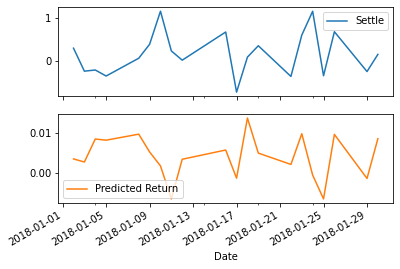

In [32]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [31]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    results["Settle"],
    results["Predicted Return"]
                        )

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print("Out-of-Sample Root Mean Squared Error (RMSE): " + str(rmse))

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136466070143276


# In-Sample Performance

Evaluate the model using in-sample data (x_train and y_train)

In [30]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Settle"],
    in_sample_results["In-sample Predictions"]
                                  )

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print("In-sample Root Mean Squared Error (RMSE): " + str(in_sample_rmse))

In-sample Root Mean Squared Error (RMSE): 0.7056790049370507


# Conclusions

<p> The Out of Sample RMSE of 0.41 is relatively close to the In Sample RMSE and therefore the model could be relied upon to make predictions based on regression analysis. 